## 第9章 最適化アラカルト

### 9.2 ソルバーの威力

In [1]:
import numpy as np
from pulp import LpProblem,LpMaximize,LpVariable,LpBinary,lpDot
def make(n):
    np.random.seed(1)  # 乱数シードを設定することで、同じ乱数を生成
    w = 1 + np.random.rand(n)
    p = w + np.random.randn(n) * 0.1
    m = LpProblem(sense=LpMaximize)
    v = [LpVariable('x%05d'%i,cat=LpBinary) for i in range(n)]
    m += lpDot(p, v)
    m += lpDot(w, v) <= int(n*1.25)
    return m

In [2]:
m = make(100)
%timeit -r3 -n3 m.solve()

194 ms ± 3.93 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


### 9.3 ナップサック問題の結果の図示

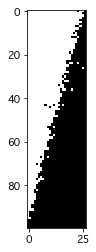

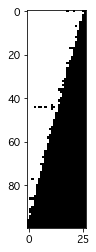

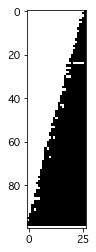

In [3]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt
from ortoolpy import knapsack  # 厳密解法
def greedy(siz, prf, capa):  # 貪欲法
    p, r = 0, []
    for i in range(len(siz)-1, -1, -1):
        if siz[i] <= capa:
            capa -= siz[i]
            p += prf[i]
            r.append(i)
    return p, r
def stingy(siz, prf, capa):  # 吝嗇法
    p, r = 0, []
    rm = siz.sum()
    for i in range(len(siz)):
        if 0 < rm-siz[i] <= capa and siz[i] <= capa:
            capa -= siz[i]
            p += prf[i]
            r.append(i)
        rm -= siz[i]
    return p, r
np.random.seed(0)
n = 100  # アイテム数
siz = np.random.uniform(0.1, 1.0, n)  # 大きさ
prf = siz * np.random.lognormal(1, 0.1, n)  # 価値
eff = prf / siz  # 効率
siz, prf, eff = np.array([siz,prf,eff]).T[eff.argsort()].T
pl1, pl2, pl3, rl1, rl2, rl3 = [], [], [], [], [], []
for capa in np.arange(2, siz.sum() + 2, 2):
    p1, r1 = knapsack(siz, prf, capa)
    pl1.append(p1)
    rl1.append([int(i in r1) for i in range(n)])
    p2, r2 = greedy(siz, prf, capa)
    pl2.append(p2)
    rl2.append([int(i in r2) for i in range(n)])
    p3, r3 = stingy(siz, prf, capa)
    pl3.append(p3)
    rl3.append([int(i in r3) for i in range(n)])
plt.imshow(1 - np.array(rl1).T, cmap='gray')
plt.show()
plt.imshow(1 - np.array(rl2).T, cmap='gray')
plt.show()
plt.imshow(1 - np.array(rl3).T, cmap='gray');

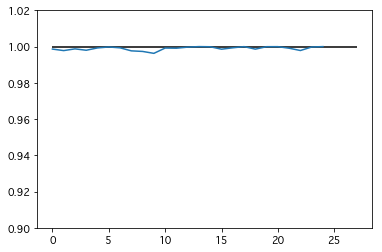

In [4]:
plt.ylim((0.9, 1.02))
plt.hlines(1, 0, len(pl1))
plt.plot(np.array(pl2[2:]) / np.array(pl1[2:]));

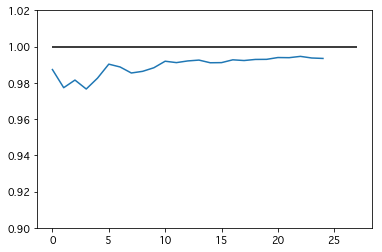

In [5]:
plt.ylim((0.9, 1.02))
plt.hlines(1, 0, len(pl1))
plt.plot(np.array(pl3[2:]) / pl1[2:]);

### 9.4 ミニサムとミニマックスとは

In [6]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pulp import LpProblem, LpBinary, lpDot, lpSum, value
from ortoolpy import addvar, addvars
商品数, ユーザ数 = 1000, 100
np.random.seed(1)
df = pd.DataFrame(np.random.rand(商品数, ユーザ数),
    index=[f'商品{i:03}' for i in range(商品数)],
    columns=[f'ユーザ{j:02}' for j in range(ユーザ数)])
addvars(df)
df[:2]

,ユーザ00,ユーザ01,ユーザ02,ユーザ03,ユーザ04,ユーザ05,ユーザ06,ユーザ07,ユーザ08,ユーザ09,...,ユーザ91,ユーザ92,ユーザ93,ユーザ94,ユーザ95,ユーザ96,ユーザ97,ユーザ98,ユーザ99,Var
商品000,0.417022,0.720324,0.000114,0.302333,0.146756,0.092339,0.186260,0.345561,0.396767,0.538817,...,0.949489,0.449912,0.578390,0.408137,0.237027,0.903380,0.573679,0.002870,0.617145,v002701
商品001,0.326645,0.527058,0.885942,0.357270,0.908535,0.623360,0.015821,0.929437,0.690897,0.997323,...,0.065961,0.735066,0.772178,0.907816,0.931972,0.013952,0.234362,0.616778,0.949016,v002702


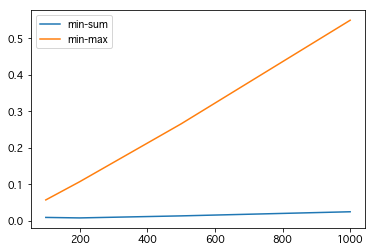

In [7]:
it = [100, 200, 500, 1000]  # 商品数リスト
tm = []
for n in it:
    dfs = df[:n]
    m1 = LpProblem()  # ミニサム問題
    m1 += lpDot(dfs.T[:-1].sum(), dfs.Var)  # 合計(サム)
    m1 += lpSum(dfs.Var) <= n // 2
    m1.solve()
    m2 = LpProblem()  # ミニマックス問題
    y = addvar()
    # y >= max(ユーザj の価値)
    for j in range(ユーザ数):
        m2 += y >= lpDot(dfs.iloc[:, j], dfs.Var)
    m2 += y  # 合計(マックス)
    m2 += lpSum(dfs.Var) <= n // 2
    m2.solve()
    tm.append((m1.solutionTime, m2.solutionTime))
plt.plot(it, tm)
plt.legend(['min-sum','min-max'], loc='upper left');

### 9.6 ビンパッキング問題に対するアプローチの比較

In [8]:
import numpy as np
from pulp import LpProblem, lpSum, lpDot
from ortoolpy import addvar, addvars, addbinvars
# n1, n2 = 3, 20 # 箱数, アイテム数
n1, n2 = 3, 12 # 箱数, アイテム数
np.random.seed(1)
sz = np.random.randint(1, 1000000, n2)  # サイズ

In [9]:
# アプローチ0
m = LpProblem()
x = np.array(addbinvars(n1, n2))
y = addvars(n1)
z = addvar()
m += z  # 目的関数
for j in range(n2):
    m += lpSum(x[:, j]) == 1
for i in range(n1):
    m += y[i] == lpSum(sz * x[i])
    m += y[i] - sum(sz)/n1 <= z
%time m.solve()

CPU times: user 4.1 ms, sys: 7.96 ms, total: 12.1 ms
Wall time: 1.05 s


1

In [10]:
# アプローチ1
m = LpProblem()
x = np.array(addbinvars(n1, n2))
y = addvars(n1)
for j in range(n2):
    m += lpSum(x[:, j]) == 1
for i in range(n1):
    m += y[i] == lpSum(sz * x[i])
#    m += y[i] <= 2646137
    m += y[i] <= 1482001
%time m.solve()

CPU times: user 5.18 ms, sys: 9.76 ms, total: 14.9 ms
Wall time: 39.6 ms


1

In [11]:
# アプローチ2
m = LpProblem()
x = np.array(addbinvars(n1, n2))
y = addvars(n1)
m += lpSum(y)  # 目的関数（なくてもよい）
for j in range(n2):
    m += lpSum(x[:, j]) == 1
for i in range(n1):
    m += y[i] == lpSum(sz * x[i])
#    m += y[i] <= 2646137
    m += y[i] <= 1482001
    if i:
        m += y[i-1] <= y[i]
%time m.solve()

CPU times: user 4.21 ms, sys: 8.01 ms, total: 12.2 ms
Wall time: 342 ms


1

In [12]:
# アプローチ3
m = LpProblem()
x = np.array(addbinvars(n1, n2))
y = addvars(n1)
z = addvar()  # max
m += z  # 目的関数
for j in range(n2):
    m += lpSum(x[:, j]) == 1
for i in range(n1):
    m += y[i] == lpSum(sz * x[i])
    m += y[i] <= z
%time m.solve()

CPU times: user 4.01 ms, sys: 7.68 ms, total: 11.7 ms
Wall time: 570 ms


1

In [13]:
# アプローチ4
m = LpProblem(sense=LpMaximize)
x = np.array(addbinvars(n1, n2))
y = addvars(n1)
z = addvar()  # min
m += z  # 目的関数
for j in range(n2):
    m += lpSum(x[:, j]) == 1
for i in range(n1):
    m += y[i] == lpSum(sz * x[i])
    m += y[i] >= z
%time m.solve()

CPU times: user 3.15 ms, sys: 4.77 ms, total: 7.91 ms
Wall time: 91.5 ms


1

In [14]:
# アプローチ5
m = LpProblem()
x = np.array(addbinvars(n1, n2))
y = addvars(n1)  # sum
z = addvars(n1)  # diff
w = addvars(n1)  # cost
m += lpSum(w)  # 目的関数
for j in range(n2):
    m += lpSum(x[:, j]) == 1
for i in range(n1):
    m += y[i] == lpSum(sz * x[i])
    m += z[i] >=  (y[i]-sum(sz)/n1)
    m += z[i] >= -(y[i]-sum(sz)/n1)
    m += w[i] >= 0.2 * z[i]
    m += w[i] >= 0.5 * z[i] - 7.5
    m += w[i] >=       z[i] - 25
%time m.solve()

CPU times: user 3.39 ms, sys: 4.64 ms, total: 8.03 ms
Wall time: 1.9 s


1

### 9.7 線形緩和問題とは

In [15]:
from pulp import (LpProblem, LpMaximize, LpBinary,
                  LpVariable, lpDot, value)
m = LpProblem(sense=LpMaximize)  # 数理モデル
x,y,z = [LpVariable(c, cat=LpBinary) for c in 'xyz'] # 変数
m += lpDot([7,8,9], [x,y,z])  # 目的関数
m += lpDot([6,7,8], [x,y,z]) <= 14  # 制約条件
m.solve()  # 求解
print([value(v) for v in [x,y,z]])  # 出力

[1.0, 0.0, 1.0]


In [16]:
from pulp import LpProblem,LpMaximize,LpVariable,lpDot,value
m = LpProblem(sense=LpMaximize)  # 数理モデル
# 変数
x,y,z = [LpVariable(c,lowBound=0,upBound=1) for c in 'xyz']
m += lpDot([7,8,9], [x,y,z])  # 目的関数
m += lpDot([6,7,8], [x,y,z]) <= 14  # 制約条件
m.solve()  # 求解
print([value(v) for v in [x,y,z]])  # 出力

[1.0, 1.0, 0.125]


In [17]:
from pulp import LpContinuous
for v in m.variables():
    v.cat = LpContinuous

### 9.8 緩和固定法

In [18]:
import pandas as pd
start = pd.datetime(2020, 1, 1)
end = pd.datetime(2020, 1, 14)
window = pd.Timedelta('7D')
fix = pd.Timedelta('3D')
last = end - window + fix - pd.Timedelta('1D')
rng = pd.date_range(start, last, freq=fix)
for i, d in enumerate(rng):
    t = d.date()
    print(f'{i+1}回目 ~{t}:fix ~{t+window}:window')

1回目 ~2020-01-01:fix ~2020-01-08:window
2回目 ~2020-01-04:fix ~2020-01-11:window
3回目 ~2020-01-07:fix ~2020-01-14:window


### 9.11 双対問題

In [19]:
import dual

In [20]:
%%dual
min c^T x
A x >= b
x >= 0

max b^T y
A^T y <= c
y >= 0


In [21]:
%%dual
max b^T y
A^T y <= c
y >= 0

min c^T x
A x >= b
x >= 0


In [22]:
%%dual
min c^T x
A x = b
x >= 0

max b^T y
A^T y <= c


In [23]:
%%dual
min c^T x
A x >= b

max b^T y
A^T y = c
y >= 0


In [24]:
%%dual
max c^T x + d^T z
A x - P z >= b
Q z <= f
x >= 0

min - b^T y + f^T w
-A^T y >= c
P^T y + Q^T w = d
y >= 0
w >= 0


In [25]:
%%dual
min - b^T y + f^T w
-A^T y >= c
P^T y + Q^T w = d
y >= 0
w >= 0

max c^T x + d^T z
Q z <= f
- A x + P z <= -b
x >= 0


### 9.12 モンテカルロ法を用いた最短路の計算

/Users/knt/.pyenv/versions/anaconda3-5.3.0/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


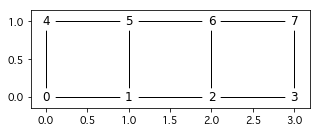

In [26]:
%matplotlib inline
import numpy as np, networkx as nx, matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 5, 1.8
m = 4  # 横の頂点数
g = nx.Graph()
for i in range(m):
    if i==0:
        g.add_edge(i, i+m, prob=[1], time=[1.9])  # 0-> 4
    else:
        g.add_edge(i, i+m, prob=[0.8,0.2], time=[1,6]) # 縦
    if i < m-1:
        g.add_edge(i, i+1, prob=[1], time=[2])  # 横
        g.add_edge(i+m, i+m+1, prob=[1], time=[2])  # 横
n = g.number_of_nodes()
pos = {i:[i%m, i//m] for i in range(n)}
nx.draw_networkx(g, pos, node_color='w')

In [27]:
def monte_min(g, s, t, nn=1000):
    n = g.number_of_nodes()
    dd = [np.inf] * n  # 到達時間
    bb = [False] * n  # 探索済み
    for _, d in g.edges.items():
        d['log'] = (np.random.multinomial(1, d['prob'], nn)
                    * d['time']).sum(axis=1)
    nx = t  # 次の点
    dd[nx] = 0
    bb[nx] = True
    while not bb[s] and not np.isposinf(dd[nx]):
        for nd in g.adj[nx]:
            dd[nd] = min(dd[nd], np.mean([calcmin(dd,
                g.adj[nd], i) for i in range(nn)]))
        nx = np.argmin([np.inf if bb[i] else dd[i]
                        for i in range(n)])
        bb[nx] = True
    return np.round(dd, 2)
def calcmin(dd, dc, i):
    return min([dd[nd]+d['log'][i] for nd,d in dc.items()])
np.random.seed(1)
monte_min(g, 0, 7)

array([7.04, 5.04, 3.17, 1.71, 6.  , 4.  , 2.  , 0.  ])

### 9.13 パズルを最適化で解く
[パズルを最適化で解く](opt4puzzle/index.ipynb)